# ASTE Release 1: Accessing the output with xmitgcm's llcreader module

The Arctic Subpolar gyre sTate Estimate (ASTE) is a medium resolution, dynamically consistent, data constrained
simulation of the ocean and sea ice state in the Arctic and subpolar gyre, spanning 2002-2017.
See details on Release 1 in [Nguyen et al, 2020].

This notebook serves as an example for accessing the output from this state estimate using xmitgcm's
[llcreader module](https://xmitgcm.readthedocs.io/en/latest/llcreader.html)
to get the output in an [xarray](http://xarray.pydata.org/en/stable/) dataset.
These capabilities heavily rely on [dask](https://dask.org/) 
to lazily grab the data as we need it.
Users are strongly encouraged to check out [dask's best practices](https://docs.dask.org/en/latest/best-practices.html)
regarding memory management before performing more advanced calculations.

Any problems due to connections with the server can be reported as a
[GitHub Issue](https://docs.github.com/en/free-pro-team@latest/github/managing-your-work-on-github/creating-an-issue)
on the [ASTE repo](https://github.com/crios-ut/aste).

---

Nguyen, An, Heimbach, P., Ocaña, V., Pillar, H., Bigdeli, A., & Smith, T. (2020). The Arctic Subpolar gyre sTate Estimate: a data-constrained and dynamically consistent ocean-sea ice estimate for 2002–2017. Submitted to Journal of Advances in Modeling Earth Systems.

In [1]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
import xarray as xr
import cmocean
from dask.distributed import Client

from xmitgcm import llcreader
import ecco_v4_py

## Get an xarray dataset with *all* ASTE_R1 variables, depth levels, and time steps

The function `get_dataset` by default grabs all available output, at all depth levels and all time steps, where each
time step represents a monthly mean for that field.
This may be suboptimal when operating on a machine with limited memory, for instance on a laptop.
See the [llcreader documentation](https://xmitgcm.readthedocs.io/en/latest/llcreader.html) for more examples
on how to subset the data with the [get_dataset method](https://xmitgcm.readthedocs.io/en/latest/llcreader.html#api-documentation),
including how to grab specific variables, vertical slices, or time steps.

In [2]:
aste = llcreader.CRIOSPortalASTE270Model()

In [3]:
ds = aste.get_dataset()

### Grab a single monthly average
Here we subset the dataset to show the ASTE ocean state during a single month, September 2012.
Alternatively, one can provide the corresponding iteration to the `iters` option in `get_dataset`
to achieve the same behavior.

In [4]:
ds = ds.sel(time='2012-09')

We are grabbing a single time slice to make this demo quick.
Of course, [xarray](http://xarray.pydata.org/en/stable/) makes it easy to compute full time mean quantities,
for example SST averaged from 2006 through 2017:
```
sst = ds['THETA'].sel(k=0,time=slice('2006','2017')).mean(dim='time')
```
but note that this will take longer than the plots below because `llcreader` has to grab
all of the 2006-2017 data from the cloud.

### Some house keeping

- rename the `faces` dimension to `tiles` (shown and discussed below)
- split the coordinate and data variables to speed things up a bit

In [5]:
ds = ds.rename({'face':'tile'})
cds = ds.coords.to_dataset().reset_coords()
ds = ds.reset_coords(drop=True)

#### A list of all the data variables

In [6]:
ncols=10
for i,f in enumerate(list(ds.data_vars),start=1):
    end = '\n' if i%ncols==0 else ', '
    print(f,end=end)

ADVr_SLT, ADVr_TH, ADVxHEFF, ADVxSNOW, ADVx_SLT, ADVx_TH, ADVyHEFF, ADVySNOW, ADVy_SLT, ADVy_TH
DETADT2, DFrE_SLT, DFrE_TH, DFrI_SLT, DFrI_TH, DFxEHEFF, DFxESNOW, DFxE_SLT, DFxE_TH, DFyEHEFF
DFyESNOW, DFyE_SLT, DFyE_TH, ETAN, ETANSQ, GM_PsiX, GM_PsiY, KPPg_SLT, KPPg_TH, MXLDEPTH
PHIBOT, SALT, SFLUX, SIaaflux, SIacSubl, SIarea, SIatmFW, SIatmQnt, SIheff, SIhsnow
SIsnPrcp, SItflux, SIuice, SIvice, SRELAX, TFLUX, THETA, TRELAX, UVELMASS, VVELMASS
WSLTMASS, WTHMASS, WVELMASS, oceFWflx, oceQnet, oceQsw, oceSPDep, oceSPflx, oceSPtnd, oceSflux
oceTAUX, oceTAUY, sIceLoad, 

#### and all the variables describing the underlying grid

In [7]:
ncols=10
for i,f in enumerate(list(cds.data_vars),start=1):
    end = '\n' if i%ncols==0 else ', '
    print(f,end=end)

niter, CS, SN, drC, drF, dxC, dxG, dyC, dyG, Depth
PHrefC, PHrefF, rA, rAs, rAw, rAz, Z, Zp1, rhoRef, XC
XG, YC, YG, hFacC, hFacS, hFacW, maskC, maskCtrlC, maskCtrlS, maskCtrlW
maskInC, maskInS, maskInW, maskS, maskW, Zl, Zu, 

and we can get some nice meta data to explain what this means thanks to `xmitgcm`+`xarray`

In [8]:
ds.ADVx_TH

,Array,Chunk
Bytes,174.96 MB,1.17 MB
Shape,"(1, 50, 6, 270, 270)","(1, 1, 2, 270, 270)"
Count,164250 Tasks,200 Chunks
Type,float64,numpy.ndarray


### A quick plot

This is just a sanity check - we have the output!

CPU times: user 917 ms, sys: 148 ms, total: 1.07 s
Wall time: 1.96 s


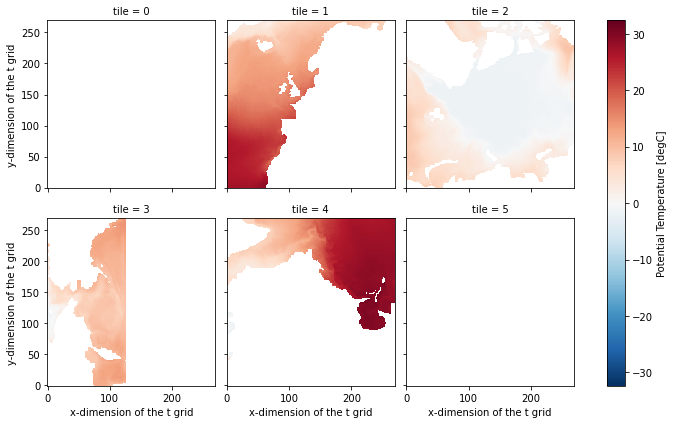

In [9]:
%%time
ds.THETA.sel(k=0).plot(col='tile',col_wrap=3)

## Use ECCOv4-py to make a nicer plot: average SST and SSS  during September, 2012

The plot above shows the "tiled" LLC grid topology of ASTE, which can be cumbersome to work with.
This grid is familiar to anyone used to the global ECCO state estimate, which
[ecco_v4_py](https://github.com/ECCO-GROUP/ECCOv4-py) is 
designed to deal with.

As of `ecco_v4_py` version 1.3.0, we can now use all the same functions with ASTE as well.
See below for an example of a nicer plot. 

See [here](https://ecco-v4-python-tutorial.readthedocs.io/fields.html#geographical-layout)
to read more about the LLC grid.

In [10]:
sst = ds['THETA'].sel(k=0)
sss = ds['SALT'].sel(k=0)

CPU times: user 33.5 s, sys: 1.66 s, total: 35.2 s
Wall time: 23.4 s


/scratch2/tsmith/miniconda3/envs/py38_tim/lib/python3.8/site-packages/matplotlib/colors.py:576: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


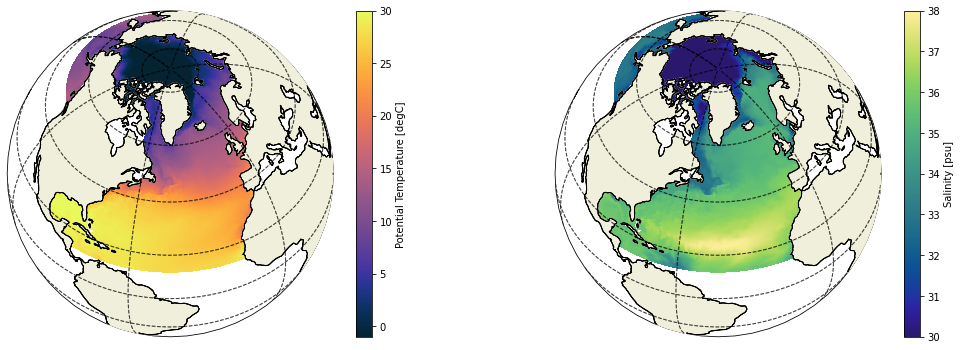

In [11]:
%%time
fig = plt.figure(figsize=(18,6))
for i,(fld,cmap,cmin,cmax) in enumerate(zip([sst,sss],
                                            ['cmo.thermal','cmo.haline'],
                                            [-1,30],[30,38]),start=1):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        fig,ax,p,cbar,*_=ecco_v4_py.plot_proj_to_latlon_grid(cds.XC,cds.YC,fld,
                                                             show_colorbar=True,
                                                             projection_type='ortho',
                                                             user_lon_0=-45,user_lat_0=50,
                                                             subplot_grid=[1,2,i],
                                                             cmap=cmap,cmin=cmin,cmax=cmax);

## Use ECCOv4-py to get velocities in the "expected" direction

The first plot showed how the rotated fields in the ASTE domain can be difficult to visualize. 
This is especially true for any vector field (e.g. zonal, meridional velocity), where the
vector components are also rotated with each "tile".
In order to visualize vector components, we can use the [vector_calc](https://github.com/ECCO-GROUP/ECCOv4-py/blob/master/ecco_v4_py/vector_calc.py)
module to perform the necessary interpolation and rotation operations.

Note that these routines are essentially simple wrappers around [xgcm](https://xgcm.readthedocs.io/en/latest/) 
Grid operations, which make all of this possible while working with [xarray](http://xarray.pydata.org/en/stable/)
and [dask](https://dask.org/).

In [12]:
# get an xgcm Grid object
grid = ecco_v4_py.get_llc_grid(cds,domain='aste')

In [13]:
%%time
uvel,vvel = ecco_v4_py.vector_calc.UEVNfromUXVY(ds['UVELMASS'].sel(k=0),
                                                ds['VVELMASS'].sel(k=0),
                                                coords=cds,
                                                grid=grid)

CPU times: user 43.6 ms, sys: 553 µs, total: 44.1 ms
Wall time: 43.3 ms


In [14]:
uvel.attrs = ds.UVELMASS.attrs
vvel.attrs = ds.VVELMASS.attrs

CPU times: user 45.7 s, sys: 3.5 s, total: 49.2 s
Wall time: 52.8 s


/scratch2/tsmith/miniconda3/envs/py38_tim/lib/python3.8/site-packages/matplotlib/colors.py:576: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


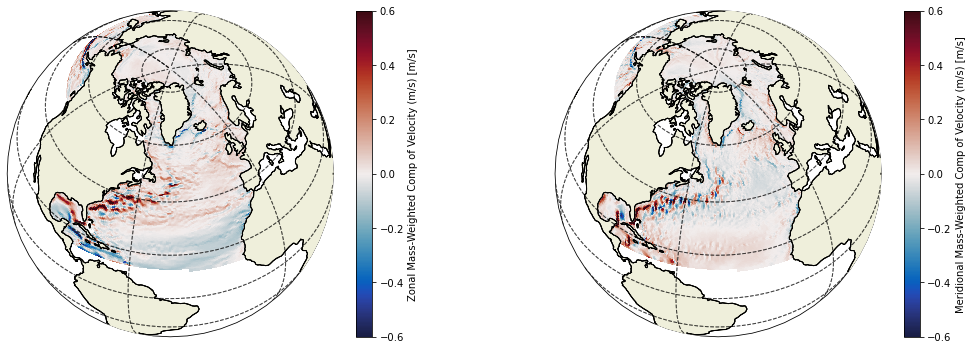

In [15]:
%%time
fig = plt.figure(figsize=(18,6))
vmax = .6
for i,(fld,cmap,cmin,cmax) in enumerate(zip([uvel,vvel],
                                            ['cmo.balance','cmo.balance'],
                                            [-vmax]*2,[vmax]*2),start=1):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        fig,ax,p,cbar,*_=ecco_v4_py.plot_proj_to_latlon_grid(cds.XC,cds.YC,fld,
                                                             show_colorbar=True,
                                                             projection_type='ortho',
                                                             user_lon_0=-45,user_lat_0=50,
                                                             subplot_grid=[1,2,i],
                                                             cmap=cmap,cmin=cmin,cmax=cmax);

## Use ECCOv4-py to compute volumetric transports: Fram Strait example

Compare to Fig. 14 of [Nguyen et al., 2020], showing the time mean:
- inflow of Atlantic waters to the Arctic = 6.2$\pm$2.3 Sv
- outflow of modified waters = -8.3$\pm$2.5 Sv

where positive indicates "toward the Arctic".

Again, we compute this quantity for a single time slice as a quick example, but this can be easily extended
to compute for example the time series of volumetric transport.

In [16]:
fsW = ecco_v4_py.calc_section_vol_trsp(ds,grid=grid,pt1=[-18.5,80.37],pt2=[1,80.14],coords=cds)
fsE = ecco_v4_py.calc_section_vol_trsp(ds,grid=grid,pt1=[1,80.14],pt2=[11.39,79.49],coords=cds)

In [17]:
fsW = fsW.swap_dims({'k':'Z'})
fsE = fsE.swap_dims({'k':'Z'})

In [18]:
plt.rcParams.update({'font.size':14})

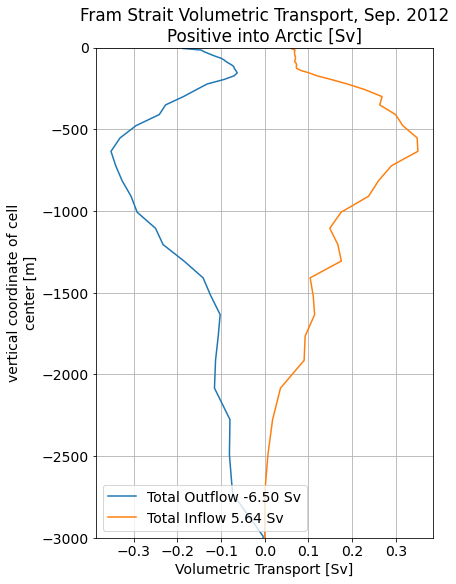

In [19]:
fig,ax = plt.subplots(1,1,figsize=(6,8),constrained_layout=True)
for vds,lbl in zip([fsW,fsE],['Outflow','Inflow']):
    mylbl = f'Total {lbl} %2.2f {vds.vol_trsp.units}' % vds.vol_trsp.values
    vds.vol_trsp_z.plot(y='Z',ax=ax,label=mylbl)
    
ax.grid(True)
ax.set(ylim=[-3000,0],
       xlabel=f'Volumetric Transport [{fsW.vol_trsp.units}]',
       title=f'Fram Strait Volumetric Transport, Sep. 2012\nPositive into Arctic [{vds.vol_trsp.units}]')
ax.legend()